# Visualization of data and model performance

## Error bars
- Use std. deviation to indicate uncertainty
- Error bar = std.dev values
- Use pandas to "filter" data on criteria (environment)
- Then for that environment - plot line plot with error bar -
- For a single column say A2C Precision

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Utility functions

In [110]:
# Write heading to summary performance file
def write_heading(heading, report_file):
    from csv import writer
    with open(report_file, 'a', newline='') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(heading)
        f_object.close()

# Write summary performance to file
def write_perf_metrics(heading, metrics, report_file, round_decimals=8):
    from pathlib import Path
    
    write_heading([''], report_file)  
    write_heading(heading, report_file)   
    report_file = Path(report_file)
    report_file.parent.mkdir(parents=True, exist_ok=True)
    metrics = metrics.round(round_decimals)
    metrics.to_csv(report_file, mode='a')
    
    write_heading(['-----------------------------------------------------------------------'], report_file)  

In [111]:
# Draw error bar plots across all training rounds
def error_plot(fig, ax, x, y, y_err, title, y_label, x_label, legend):
    TIME_STEP_TICK = 1
    X_LOW = -0.25
    X_UPPER = len(x)
    Y_LOW = 0.0
    Y_UPPER = 1.1
    Y_GRID = 0.25

    ax.errorbar(x, y, yerr=y_err, fmt='-o', alpha=0.5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title, fontsize=12)
    ax.set(ylim=[Y_LOW, Y_UPPER])
    ax.set_xticks(np.arange(0, X_UPPER, TIME_STEP_TICK))
    ax.set_xticklabels(x[::TIME_STEP_TICK], fontdict={'fontsize':10})
    
    ax.grid(alpha=0.25)
    ax.spines["top"].set_alpha(0)
    ax.spines["bottom"].set_alpha(.3)
    ax.spines["right"].set_alpha(0)
    ax.spines["left"].set_alpha(.3)
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(legend, loc='center left', bbox_to_anchor=(1, 0.8))
    pdf_file = title.replace('-', '')
    pdf_file = pdf_file.replace(' ', '_')
    fig.savefig(f'{pdf_file}.pdf', bbox_inches='tight')

In [112]:
# Draw multi-line plots for all algorithms
def multi_algorithm_plot(env_subset, env_label):
    # Create a figure with 1 row and 3 cols of subplots
    PLOT_H = 3
    PLOT_W = 20

    # define the standard algorithms and labels
    metric_key = ['Pr', 'Rc', 'F1', 'F05']
    algo_keys = ['REINFORCE', 'A2C', 'DQN', 'PPO']
    algos = {'REINFORCE':'RF', 'A2C':'A2C', 'DQN':'DQN', 'PPO':'PPO'}
    metrics = {'Pr':'Precision', 'Rc':'Recall', 'F1':'F-1 score', 'F05':'F-beta 0.5'}

    # X axis is fixed
    x_label = 'Training round'
    legend = algo_keys
    
    metrics_df = []
    
    for m in range(len(metric_key)):
        # Multi-line plots
        fig, ax = plt.subplots()

        fig.set_figheight(PLOT_H)
        fig.set_figwidth(PLOT_W)

        # axes = [ax1, ax2, ax3, ax4]
        for n in range(len(algo_keys)):
            m_key = metric_key[m]
            key = algos[algo_keys[n]] 
            mr_key = f'{key}_{m_key}'
            mr_sd_key = f'{key}_{m_key}_sd'
            mr = env_subset.groupby(['Round']).agg({mr_key :['mean']})
            mr_sd = env_subset.groupby(['Round']).agg({mr_sd_key :['mean']})

            y = mr.to_numpy().flatten().tolist()
            y_err = mr_sd.to_numpy().flatten().tolist()        
            y_label = metrics[m_key]
            title = f'{env_label} - {y_label}'

            x = [i for i in range(len(y))]
            error_plot(fig, ax, x, y, y_err, title, y_label, x_label, legend)            


# Concat experiment files

In [113]:
import glob

PATH = './results/MultiRound/!Final_Analysis/Analysis/Combined-R1-R2-R3/'
EXPT_REPORTS = f'{PATH}/Concat_Experiments_R?B.csv'
CONCAT_REPORT = f'{PATH}/Concat_Experiments_R1B_R2B.csv'
CONSOLIDATED_PERFORMANCE_REPORT = f'{PATH}/Consolidated_Experiments_Summary_R1B_R2B.csv'

report_files = glob.glob(EXPT_REPORTS)

df_report = pd.concat((pd.read_csv(f, header = 0) for f in report_files))
df_report.to_csv(CONCAT_REPORT)

def compute_aggregated_metrics(df):
    metrics = df.groupby(['environment_info']).agg(
        {'RF_Pr': ['mean'], 'RF_Rc': ['mean'],'RF_F1': ['mean'], 'RF_F05': ['mean'],
         'A2C_Pr': ['mean'], 'A2C_Rc': ['mean'],'A2C_F1': ['mean'], 'A2C_F05': ['mean'],
         'DQN_Pr': ['mean'], 'DQN_Rc': ['mean'],'DQN_F1': ['mean'], 'DQN_F05': ['mean'],
         'PPO_Pr': ['mean'], 'PPO_Rc': ['mean'],'PPO_F1': ['mean'], 'PPO_F05': ['mean'],

         'RF_Pr_sd': ['mean'], 'RF_Rc_sd': ['mean'],'RF_F1_sd': ['mean'], 'RF_F05_sd': ['mean'],
         'A2C_Pr_sd': ['mean'], 'A2C_Rc_sd': ['mean'],'A2C_F1_sd': ['mean'], 'A2C_F05_sd': ['mean'],
         'DQN_Pr_sd': ['mean'], 'DQN_Rc_sd': ['mean'],'DQN_F1_sd': ['mean'], 'DQN_F05_sd': ['mean'],
         'PPO_Pr_sd': ['mean'], 'PPO_Rc_sd': ['mean'],'PPO_F1_sd': ['mean'], 'PPO_F05_sd': ['mean']

        })
    return(metrics)

algo_metrics = compute_aggregated_metrics(df_report)
algo_metrics.to_csv(CONSOLIDATED_PERFORMANCE_REPORT)
print(f'* Done. {len(report_files)} Experiment files summarized and environment level metrics computed')

report_files

* Done. 2 Experiment files summarized and environment level metrics computed


['./results/MultiRound/!Final_Analysis/Analysis/Combined-R1-R2-R3\\Concat_Experiments_R1B.csv',
 './results/MultiRound/!Final_Analysis/Analysis/Combined-R1-R2-R3\\Concat_Experiments_R2B.csv']

In [114]:
# Import Data
df = pd.read_csv(CONCAT_REPORT)
# df = pd.read_csv('R1-Concat_Experiments.csv')
print('Experiments data imported. Number of records: ', len(df.index),'\n')

# Find unique environments
envs = df.environment_info.unique()
n_envs = len(envs)
print(f'Unique environments: {n_envs}\n {envs}')

Experiments data imported. Number of records:  150 

Unique environments: 15
 ['Simulated NBD' 'Simulated LBD' 'Simulated HBD' 'PHM C01 SS NBD'
 'PHM C01 SS LBD' 'PHM C01 SS HBD' 'PHM C04 SS NBD' 'PHM C04 SS LBD'
 'PHM C04 SS HBD' 'PHM C06 SS NBD' 'PHM C06 SS LBD' 'PHM C06 SS HBD'
 'PHM C01 MS NBD' 'PHM C04 MS NBD' 'PHM C06 MS NBD']


In [115]:
all_envs = df

simulated_env = df[(df['environment_info'] == envs[0]) |  (df['environment_info'] == envs[1]) | (df['environment_info'] == envs[2])]

ss_env = df[(df['environment_info'] == envs[3]) |  (df['environment_info'] == envs[4]) | (df['environment_info'] == envs[5]) |
            (df['environment_info'] == envs[6]) |  (df['environment_info'] == envs[7]) | (df['environment_info'] == envs[8]) |
            (df['environment_info'] == envs[9]) |  (df['environment_info'] == envs[10]) | (df['environment_info'] == envs[11])]

ms_env = df[(df['environment_info'] == envs[12]) |  (df['environment_info'] == envs[13]) | (df['environment_info'] == envs[14])]

print(f'Total: Simulated: {len(simulated_env)} SS: {len(ss_env)} MS: {len(ms_env)}')
print(f'Per variant: Simulated: {len(simulated_env)/3} SS: {len(ss_env)/9} MS: {len(ms_env)/3}')


Total: Simulated: 30 SS: 90 MS: 30
Per variant: Simulated: 10.0 SS: 10.0 MS: 10.0


## Overall

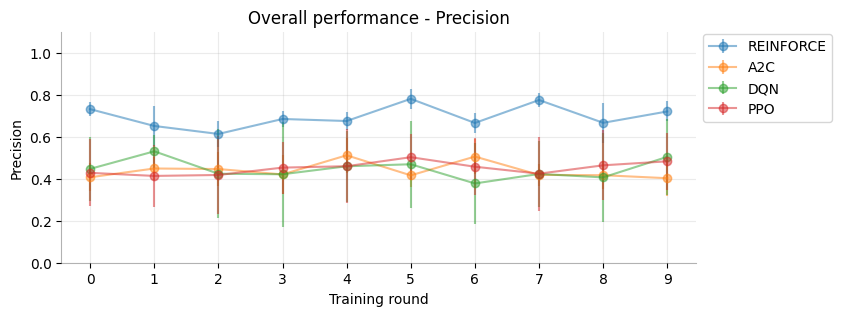

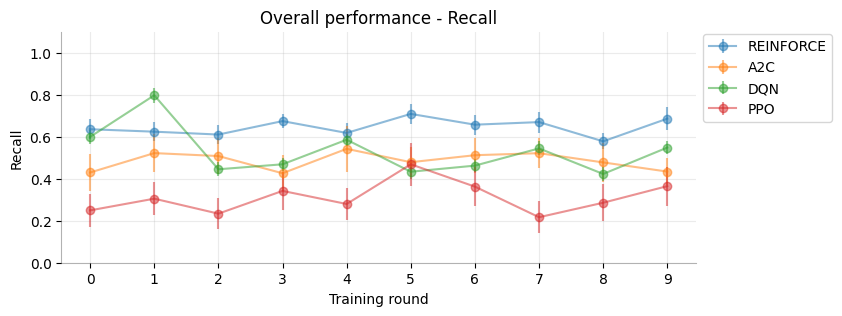

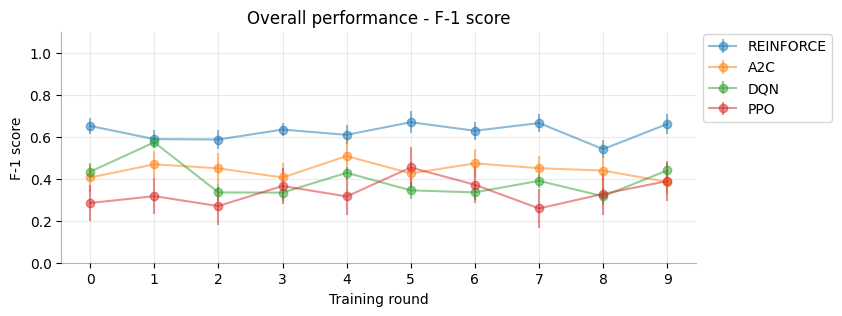

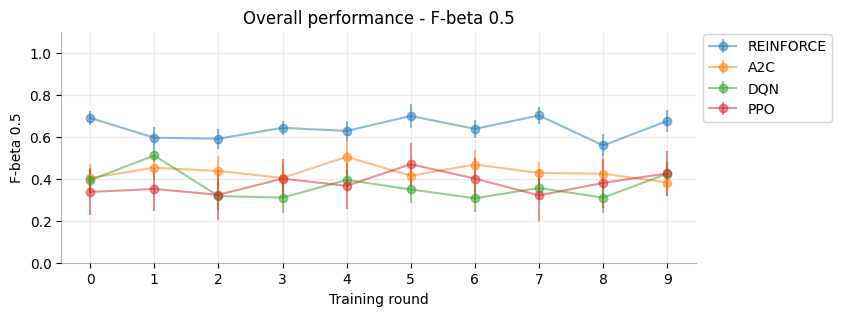

In [116]:
subset = df
env_label = 'Overall performance'
multi_algorithm_plot(env_subset=subset, env_label=env_label)

### Simulation Environment Dasic 2006

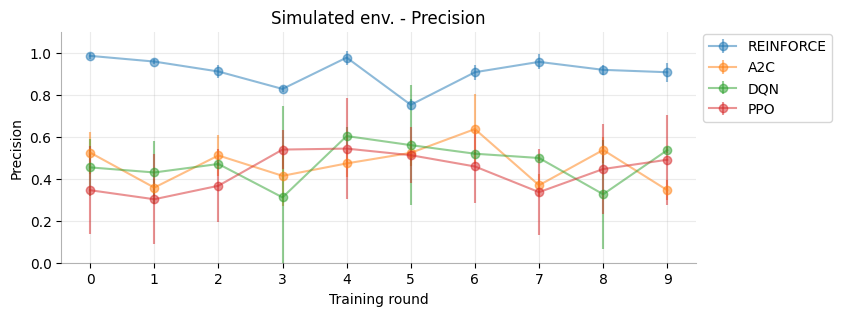

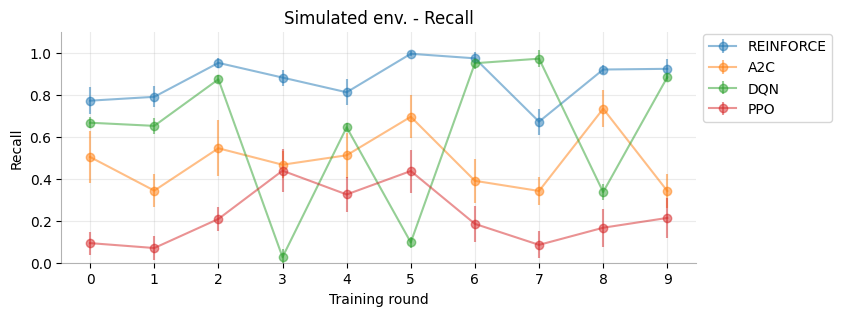

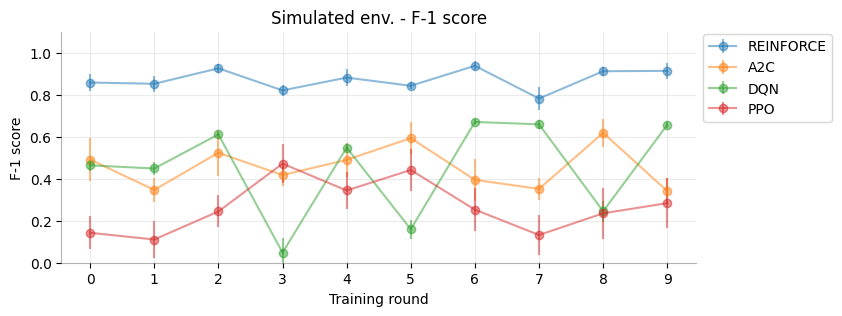

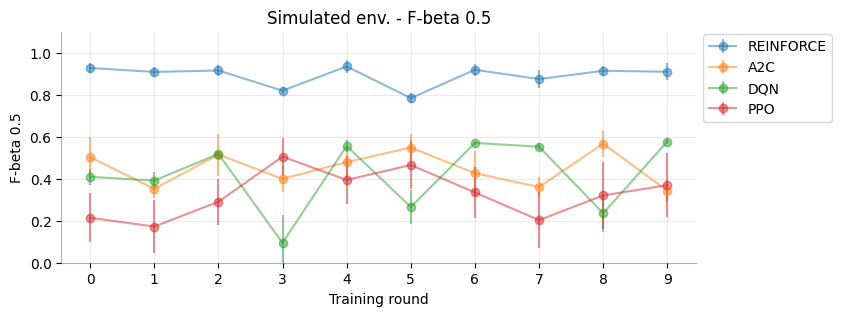

In [117]:
subset = simulated_env
env_label = 'Simulated env.'
multi_algorithm_plot(env_subset=subset, env_label=env_label)

### Singe state simple env

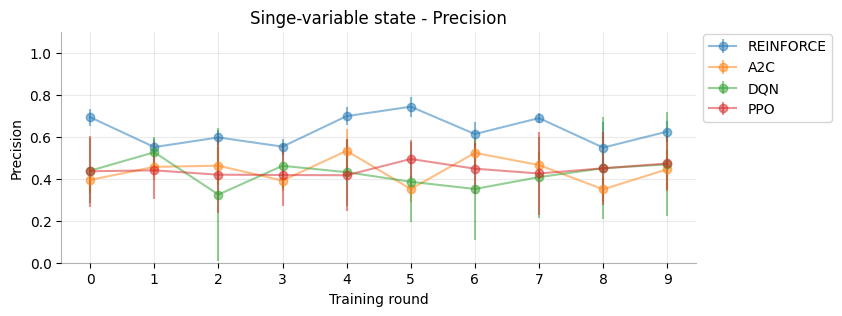

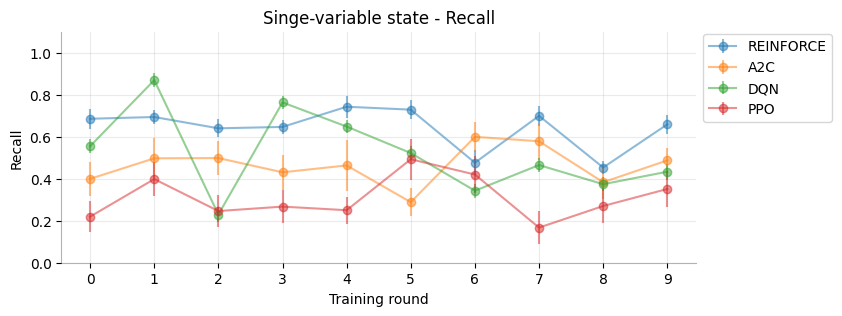

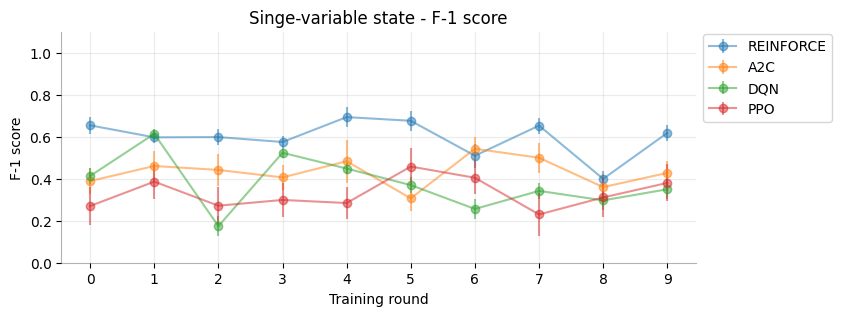

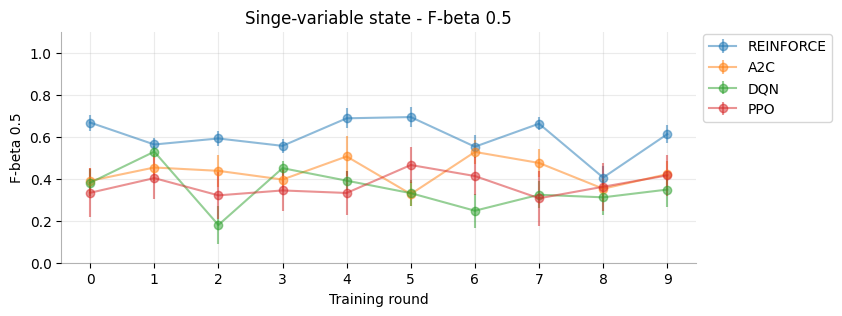

In [118]:
subset = ss_env
env_label = 'Singe-variable state'
multi_algorithm_plot(env_subset=subset, env_label=env_label)

### Multi-variate state

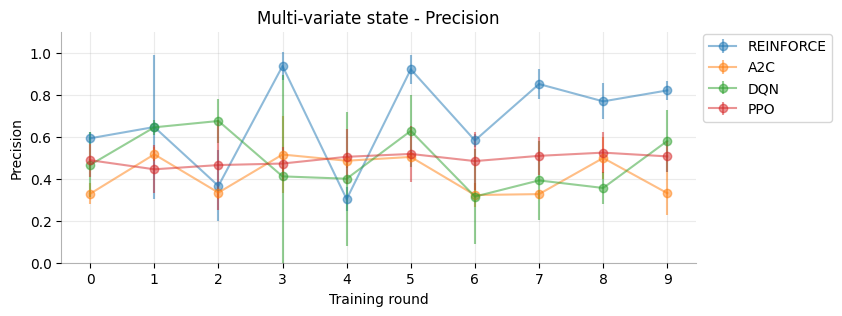

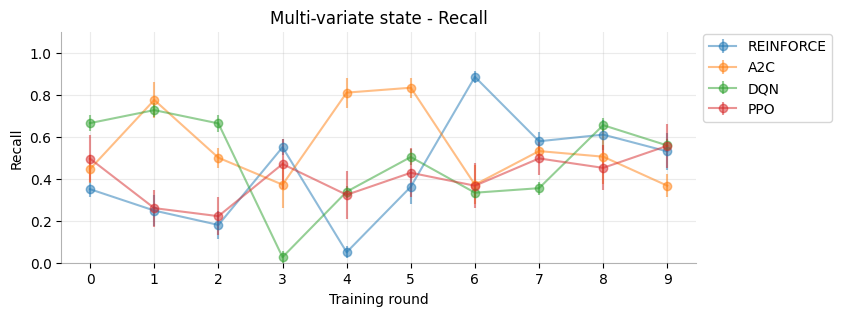

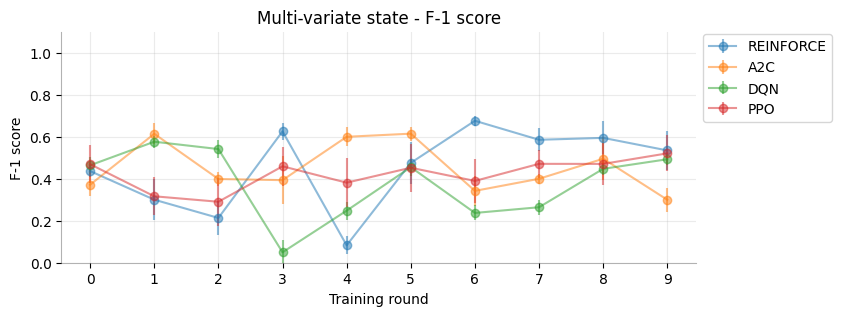

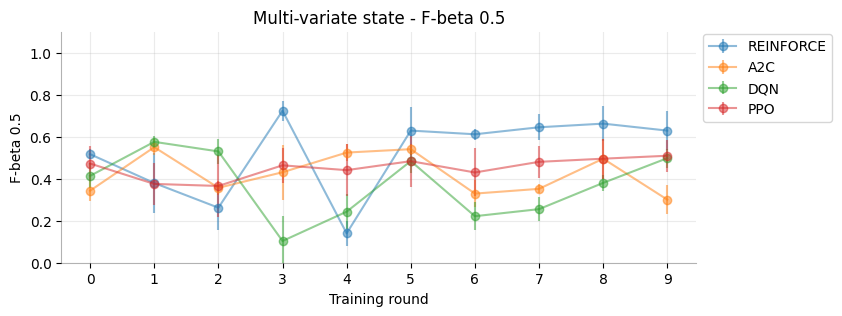

In [119]:
subset = ms_env
env_label = 'Multi-variate state'
multi_algorithm_plot(env_subset=subset, env_label=env_label)

## Compute environment specific performance metrics

In [120]:
def compute_performance_df(env_subset):
    # Standard keys and labels
    metric_key = ['Pr', 'Rc', 'F1', 'F05']
    algo_keys = ['REINFORCE', 'A2C', 'DQN', 'PPO']
    algos = {'REINFORCE':'RF', 'A2C':'A2C', 'DQN':'DQN', 'PPO':'PPO'}
    metrics = {'Pr':'Precision', 'Rc':'Recall', 'F1':'F-1 score', 'F05':'F-beta 0.5'}

    # Performance columns
    metric_cols = ['Pr_mean', 'Pr_sd', 'Rc_mean', 'Rc_sd', 'F1_mean', 'F1_sd', 'F05_mean', 'F05_sd']

    # Initiatlize an empty pandas data fram to hold performance mentrics
    performance_df = pd.DataFrame(np.zeros((4, 8)), index=algo_keys)
    performance_df.columns = metric_cols

    # Compute metrics and fill df
    for n in range(len(algo_keys)): 

        for m in range(len(metric_key)):
            m_key = metric_key[m]
            algo_key = algos[algo_keys[n]] 
            algo_label = algo_keys[n]
            mr_key = f'{algo_key}_{m_key}'
            mr_sd_key = f'{algo_key}_{m_key}_sd'

            mr = env_subset.groupby(['Round']).agg({mr_key :['mean']})
            mr_sd = env_subset.groupby(['Round']).agg({mr_sd_key :['mean']})

            mr_mean = np.mean(mr.to_numpy().flatten())
            mr_stddev = np.mean(mr_sd.to_numpy().flatten())

            mean_col = f'{m_key}_mean' 
            sd_col = f'{m_key}_sd'

            performance_df.at[algo_label, mean_col] = mr_mean.round(4)
            performance_df.at[algo_label, sd_col] = mr_stddev.round(4)
    return (performance_df)

In [121]:
overall_performance = compute_performance_df(all_envs)
simulated_performance = compute_performance_df(simulated_env)
phm_ss_performance = compute_performance_df(ss_env)
phm_ms_performance = compute_performance_df(ms_env)

In [122]:
performance_file = 'Performance_Metrics_v2.csv'

write_perf_metrics(['Overall Performance'], overall_performance, performance_file, 4)
write_perf_metrics(['Simulated Performance'], simulated_performance, performance_file, 4)
write_perf_metrics(['PHM Single-variable state Performance'], phm_ss_performance, performance_file, 4)
write_perf_metrics(['PHM Multi-variate state Performance'], phm_ms_performance, performance_file, 4)

## Training times of algorithms across then entire experment

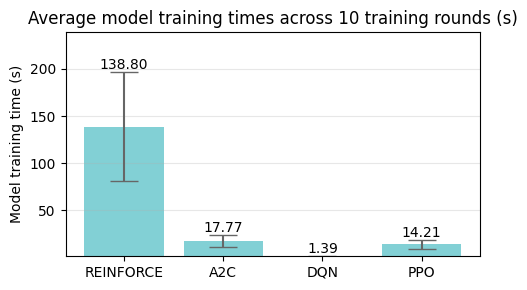

In [125]:
algo_keys = ['REINFORCE', 'A2C', 'DQN', 'PPO']
algos = {'REINFORCE':'RF', 'A2C':'A2C', 'DQN':'DQN', 'PPO':'PPO'}

RF_training_time = all_envs.agg({'RF_time':['mean','std']})
A2C_training_time = all_envs.agg({'A2C_time':['mean','std']})
DQN_training_time = all_envs.agg({'DQN_time':['mean','std']})
PPO_training_time = all_envs.agg({'PPO_time':['mean','std']})

# Create lists for the plot
x_pos = np.arange(len(algo_keys))
mean_training_time = [RF_training_time['RF_time']['mean'], A2C_training_time['A2C_time']['mean'], 
                      DQN_training_time['DQN_time']['mean'], PPO_training_time['PPO_time']['mean']]
error = [RF_training_time['RF_time']['std'], A2C_training_time['A2C_time']['std'], 
                      DQN_training_time['DQN_time']['std'], PPO_training_time['PPO_time']['std']]



# Build the plot
fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(5)

max_y_lim = max(mean_training_time) + 100
min_y_lim = min(mean_training_time)
plt.ylim(min_y_lim, max_y_lim)

bars = ax.bar(x_pos, mean_training_time, yerr=error, align='center', alpha=0.5, color='#06A2AC', ecolor = '0.4', capsize=10)
ax.set_ylabel('Model training time (s)')
ax.set_xticks(x_pos)
ax.set_xticklabels(algo_keys)
ax.set_title('Average model training times across 10 training rounds (s)')
ax.yaxis.grid(True, alpha=0.30)
ax.bar_label(bars, fmt='%.2f', label_type='edge')

# Save the figure and show
plt.tight_layout()
plt.savefig('Model_training_time.pdf', bbox_inches='tight')
plt.show()